In [37]:
# import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import utils as sk_utils
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2

from IPython.display import clear_output
clear_output()
print(tf.__version__)

2.14.0


In [38]:
import glob
image_size = (192, 256)

# 이미지를 불러오고 전처리하는 함수
def load_image(file_path, is_x=False):
    # tf.io.read_file을 사용하여 이미지 파일을 읽음
    image = tf.io.read_file(file_path)
    # 이미지를 텐서로 디코드함
    image = tf.image.decode_image(image)
    
    if is_x:
        # tf.image.resize를 사용하여 원하는 크기로 이미지를 리사이즈함. 여기서는 Lanczos3 메소드를 사용
        image = tf.image.resize(image, image_size, method=tf.image.ResizeMethod.LANCZOS3)
        image = image / 255.0  # 이미지를 정규화함(0~1 사이의 값으로 변환)
    else:
        # 'nearest' 메소드를 사용하여 원하는 크기로 이미지를 리사이즈함. 이때는 antialias=True 옵션을 사용
        image = tf.image.resize(image, image_size, method='nearest', antialias=True)
    return image


In [39]:
# 이미지 파일과 마스크 파일의 경로를 지정합니다.
image_paths = 'data/dehazed_image.jpg'
mask_path = 'data/Image_train_color.png'

# 이미지와 마스크를 불러옵니다.
X_val = [load_image(image_path, True)]  # 이미지를 불러와서 전처리한 후 X_val에 추가
Y_val = [load_image(mask_path)]  # 마스크 이미지를 불러와서 전처리한 후 Y_val에 추가

# 리스트를 NumPy 배열로 변환
X_val = np.array(X_val)
Y_val = np.array(Y_val)

# 255는 알 수 없는 객체를 나타냄
Y_val[Y_val == 255] = 19


In [40]:
# 유틸리티 함수들

import numpy as np
import matplotlib.pyplot as plt

# 각 클래스에 대한 색상을 정의하는 딕셔너리
color_dict = {
    0: (0.7, 0.7, 0.7),     # 도로 - 회색
    1:  (0.9, 0.9, 0.2),     # 보도 - 연한 노랑
    2: (1.0, 0.4980392156862745, 0.054901960784313725),
    3: (1.0, 0.7333333333333333, 0.47058823529411764),
    4: (0.8, 0.5, 0.1),  # 울타리 - 녹슨 오렌지
    5: (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
    6: (0.325, 0.196, 0.361),
    7: (1.0, 0.596078431372549, 0.5882352941176471),
    8:  (0.2, 0.6, 0.2),     # 식물 - 녹색
    9: (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
    10: (0.5, 0.7, 1.0),     # 하늘 - 연한 파랑
    11: (1.0, 0.0, 0.0), # 사람 - 빨강
    12: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
    13: (0.0, 0.0, 1.0),  # 차 - 파랑
    14: (0.0, 0.0, 1.0),  # 트랙 - 파랑
    15: (0.0, 0.0, 1.0),  # 버스 - 파랑
    16: (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
    17: (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
    18: (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
    19: (0, 0, 0) # 알 수 없음 - 검정
}

# 이미지를 색상화하는 함수
def colorize_image(image, color_dict):
    # 불필요한 차원 제거
    image = np.squeeze(image)
    # 색상 딕셔너리를 사용하여 색상화된 이미지 생성
    colored_image = np.zeros((image.shape[0], image.shape[1], 3))

    # 각 픽셀 값에 대해 색상 딕셔너리에서 색상을 찾아 이미지에 적용
    for pixel_value, color in color_dict.items():
        colored_image[image == pixel_value] = color

    # 이미지를 8비트 부호 없는 정수로 변환
    colored_image = (colored_image * 255).astype(np.uint8)

    return colored_image


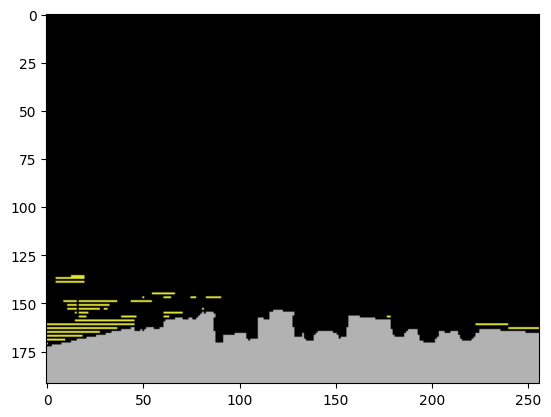

In [41]:
# 훈련 세트에서 일부 샘플 시각화
# 그림의 크기 설정

plt.imshow(colorize_image(Y_val, color_dict))  # 마스크 이미지를 색깔별로 구분하여 그래프로 표현

AA = colorize_image(Y_val, color_dict)
